In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest




import ast
import numpy as np
import matplotlib.pyplot as plt
import nbimporter
import nbformat
from Data_preparation import train_test_split_for_data_autoencoder
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Dense
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from keras.models import Sequential
from autoencoder_module import AutoEncoder


## Functions to work with

In [2]:
def difference_calculating_function_cosine_dissimilarity(predictions, real_count_vectors):
    difference_vector = np.zeros(len(predictions))
    
    #Loop through each pair of corresponding vectors
    for i in range(len(predictions)):
        vector_a = predictions[i]
        vector_b = real_count_vectors[i]
            
        dot_product = np.dot(vector_a, vector_b)
        norm_a = np.linalg.norm(vector_a)
        norm_b = np.linalg.norm(vector_b)
            
        cosine_similarity = dot_product / (norm_a * norm_b)
        difference_vector[i] = 1 - cosine_similarity
        
    return difference_vector

def difference_calculating_function_l_norm(predictions,  real_count_vectors):
    difference_vector = np.zeros(len(predictions))
    for i in range(len(predictions)):
        vector_a = predictions[i]
        vector_b = real_count_vectors[i]

        difference_vector[i] = np.linalg.norm(vector_a-vector_b, ord = 1)
    return difference_vector

## Fully unsupervised

In [3]:
numbers_of_neurons = [[48,32,16,8,4,8,16,32,48],
                      [48,24,8,4,8,24,48],
                      [48,24,12,4,12,24,48],
                      [48,16,8,4,8,16,48],
                      [48,32,24,16,8,4,8,16,24,32,48]]
activation_functions = []
kernel_initializers = []
for i in range(len(numbers_of_neurons)):
    activation_functions.append(['relu']*len(numbers_of_neurons[i]))
    kernel_initializers.append(['he_uniform']*len(numbers_of_neurons[i]))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 48)             │         1,584 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,932 (27.08 KB)

 Trainable params: 6,932 (27.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11501/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7481
Epoch 1: val_loss improved from inf to 0.46059, saving model to ../Models/model1/autoencoder_model_unsupervised_nonsequential.keras
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 1.7480 - val_loss: 0.4606
Epoch 2/100
11483/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3863
Epoch 2: val_loss improved from 0.46059 to 0.46028, saving model to ../Models/model1/autoencoder_model_unsupervised_nonsequential.keras
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.3863 - val_loss: 0.4603
Epoch 3/100
11476/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3967
Epoch 3: val_loss did not improve from 0.46028
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.3967 - val_loss: 0.4614
Epoch 4/100
11485/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3864
Epoch 4: val_loss improved from 0.46028 to 0.46025, saving model to ../Models/model1/autoencoder_model_unsupervised_nonsequential.keras
11502/11502 ━━━━━━━━━

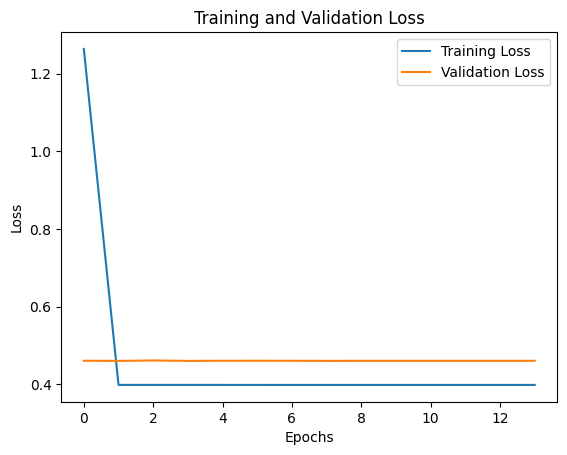

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


<Figure size 640x480 with 0 Axes>

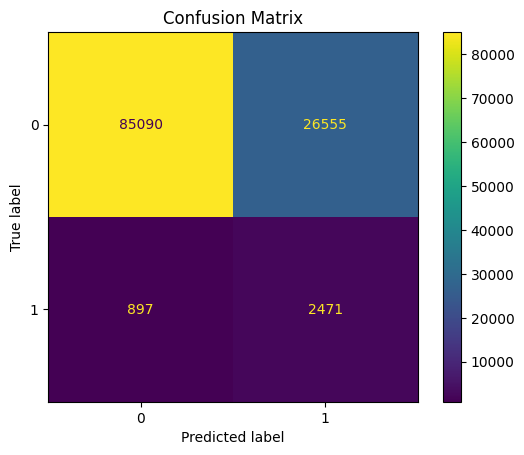

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


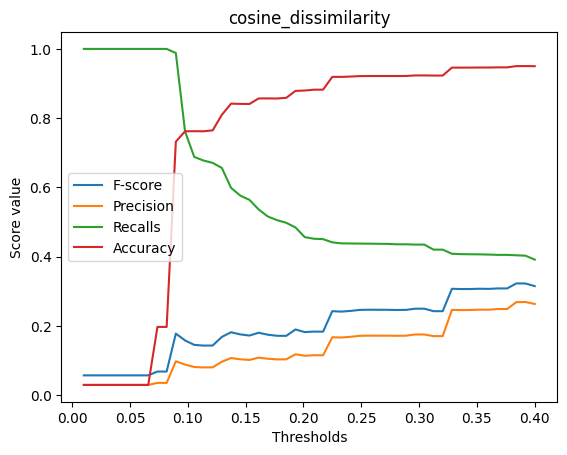

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


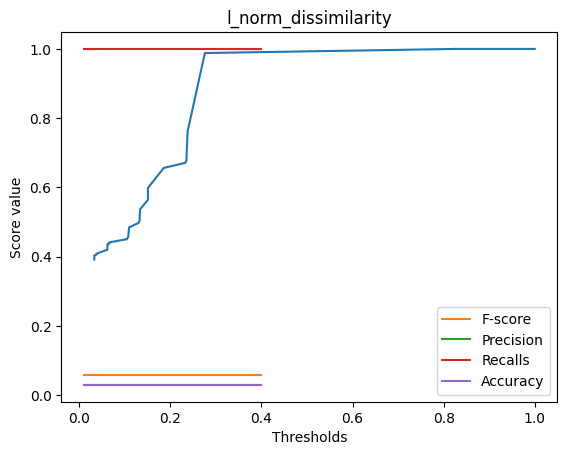

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 24)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 48)             │         1,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,220 (20.39 KB)

 Trainable params: 5,220 (20.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11459/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2797
Epoch 1: val_loss improved from inf to 0.51635, saving model to ../Models/model2/autoencoder_model_unsupervised_nonsequential.keras
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.2800 - val_loss: 0.5163
Epoch 2/100
11493/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4097
Epoch 2: val_loss improved from 0.51635 to 0.25788, saving model to ../Models/model2/autoencoder_model_unsupervised_nonsequential.keras
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.4096 - val_loss: 0.2579
Epoch 3/100
11494/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2562
Epoch 3: val_loss did not improve from 0.25788
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.2562 - val_loss: 0.3321
Epoch 4/100
11501/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2516
Epoch 4: val_loss did not improve from 0.25788
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.2516 - val_loss: 0.3326
Epoch 5/100
11490/11502 ━━━━━━

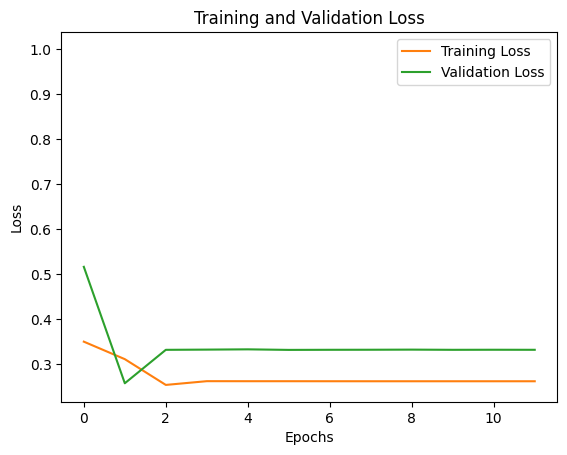

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


<Figure size 640x480 with 0 Axes>

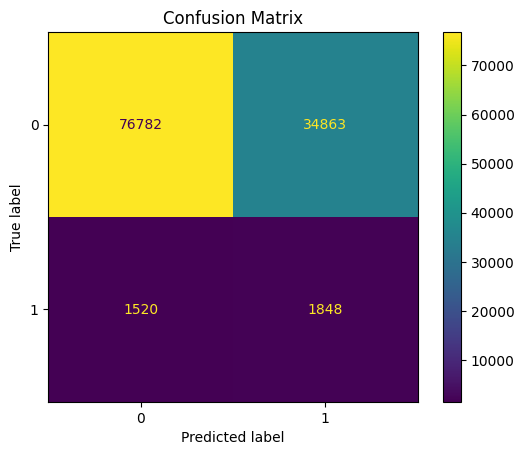

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


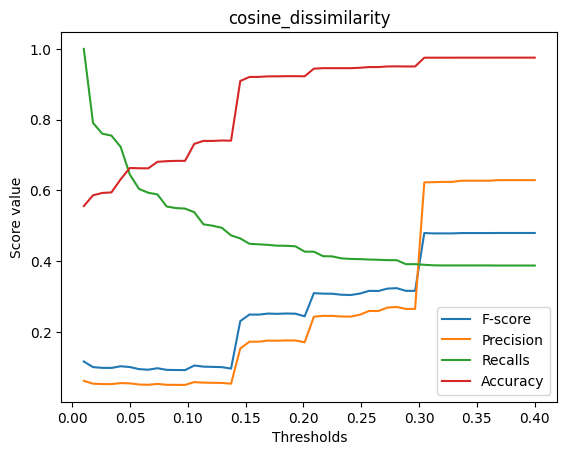

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


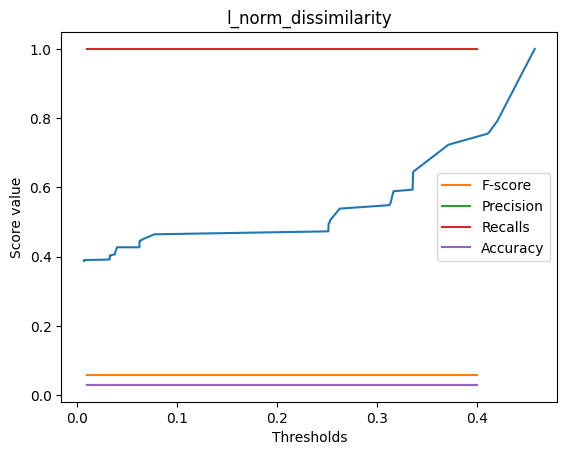

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 12)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 48)             │         1,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,452 (21.30 KB)

 Trainable params: 5,452 (21.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11463/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1777
Epoch 1: val_loss improved from inf to 0.34495, saving model to ../Models/model3/autoencoder_model_unsupervised_nonsequential.keras
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 0.1779 - val_loss: 0.3450
Epoch 2/100
11481/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2892
Epoch 2: val_loss improved from 0.34495 to 0.34414, saving model to ../Models/model3/autoencoder_model_unsupervised_nonsequential.keras
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.2892 - val_loss: 0.3441
Epoch 3/100
11483/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2738
Epoch 3: val_loss improved from 0.34414 to 0.34358, saving model to ../Models/model3/autoencoder_model_unsupervised_nonsequential.keras
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.2738 - val_loss: 0.3436
Epoch 4/100
11497/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2671
Epoch 4: val_loss did not improve from 0.34358
11502/11502 ━━━━━━━━━

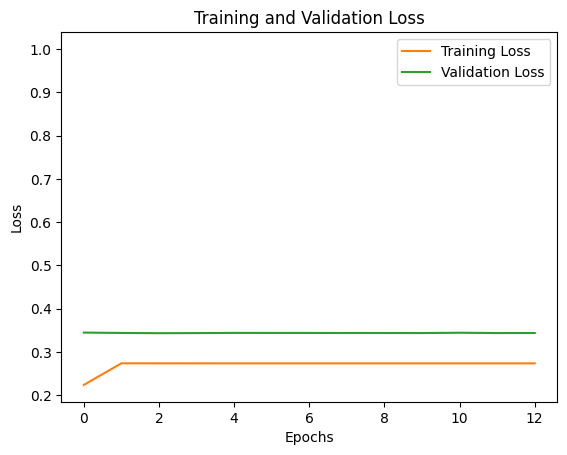

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


<Figure size 640x480 with 0 Axes>

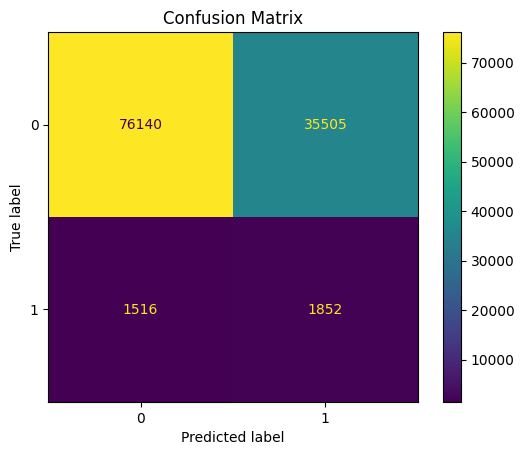

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


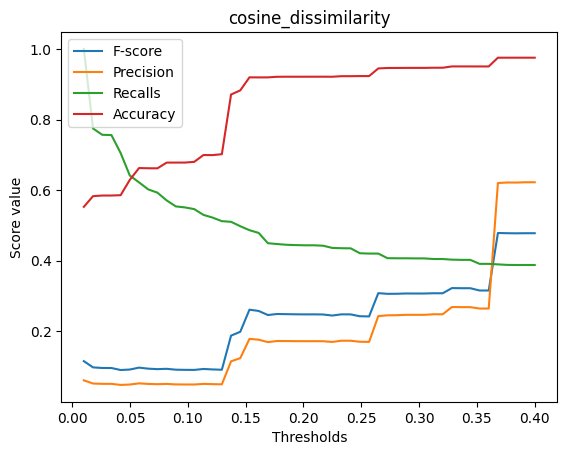

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 969us/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 3s 941us/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 973us

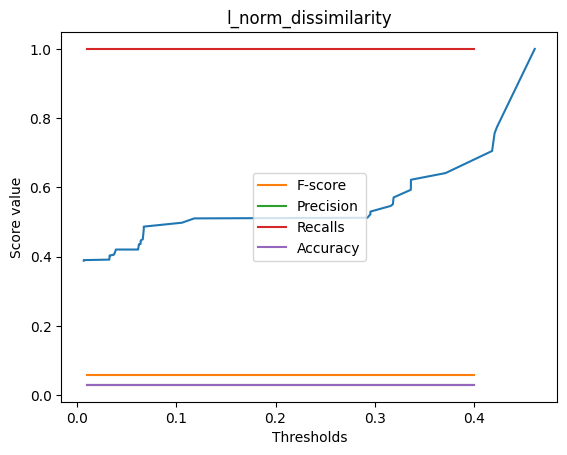

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 48)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,308 (16.83 KB)

 Trainable params: 4,308 (16.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11486/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3299
Epoch 1: val_loss improved from inf to 0.42879, saving model to ../Models/model4/autoencoder_model_unsupervised_nonsequential.keras
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 0.3300 - val_loss: 0.4288
Epoch 2/100
11476/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3765
Epoch 2: val_loss did not improve from 0.42879
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.3765 - val_loss: 0.4289
Epoch 3/100
11465/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3835
Epoch 3: val_loss did not improve from 0.42879
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.3834 - val_loss: 0.4288
Epoch 4/100
11476/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3743
Epoch 4: val_loss improved from 0.42879 to 0.42850, saving model to ../Models/model4/autoencoder_model_unsupervised_nonsequential.keras
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.3743 - val_loss: 0.4285
Epoch 5/100
11458/11502 ━━━━━━

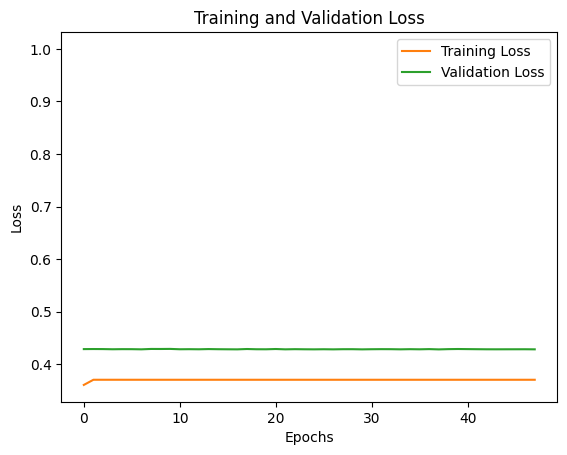

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


<Figure size 640x480 with 0 Axes>

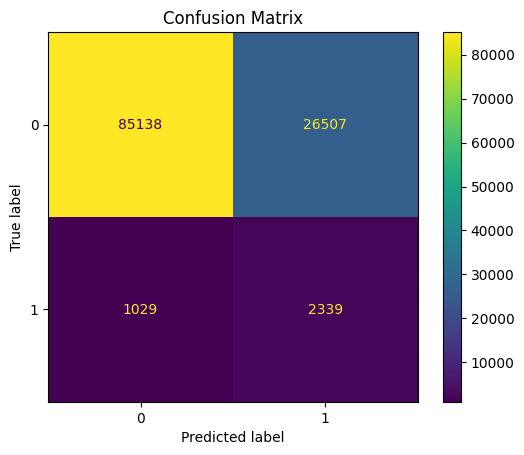

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


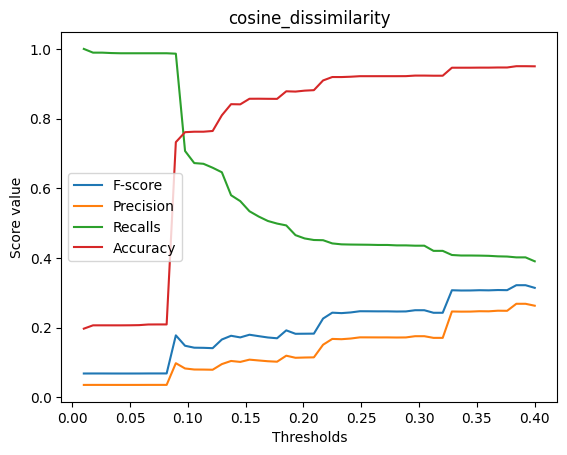

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step 
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 978us/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/st

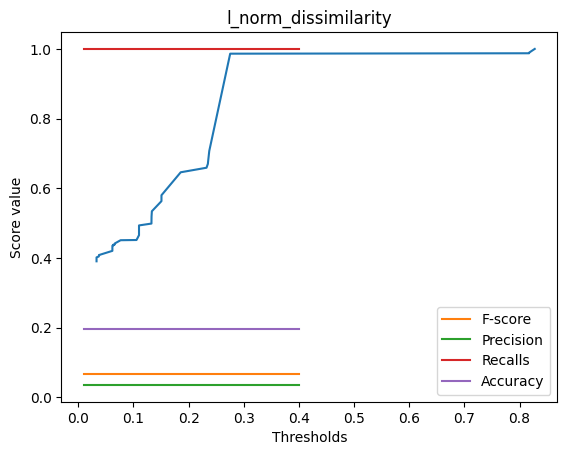

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 48)             │         1,584 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,260 (32.27 KB)

 Trainable params: 8,260 (32.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11500/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2108
Epoch 1: val_loss improved from inf to 0.28038, saving model to ../Models/model5/autoencoder_model_unsupervised_nonsequential.keras
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 0.2108 - val_loss: 0.2804
Epoch 2/100
11494/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44.4126
Epoch 2: val_loss did not improve from 0.28038
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 44.4194 - val_loss: 0.5130
Epoch 3/100
11482/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4007
Epoch 3: val_loss did not improve from 0.28038
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.4005 - val_loss: 0.3252
Epoch 4/100
11474/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2406
Epoch 4: val_loss did not improve from 0.28038
11502/11502 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.2406 - val_loss: 0.3321
Epoch 5/100
11498/11502 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2609
Epoch 5: val_loss did not improve from 0.2803

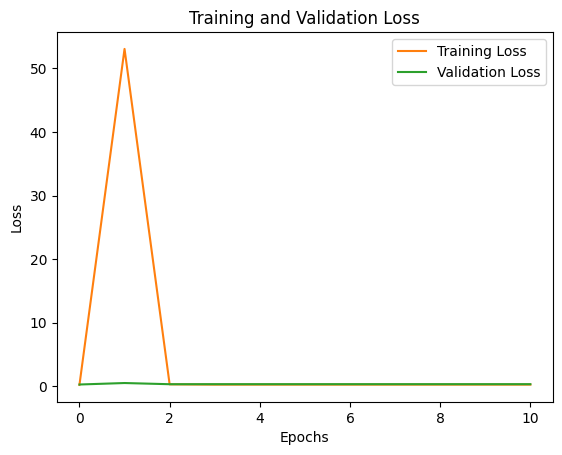

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


<Figure size 640x480 with 0 Axes>

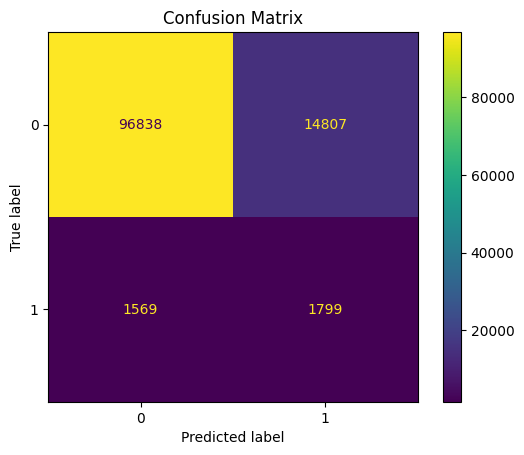

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


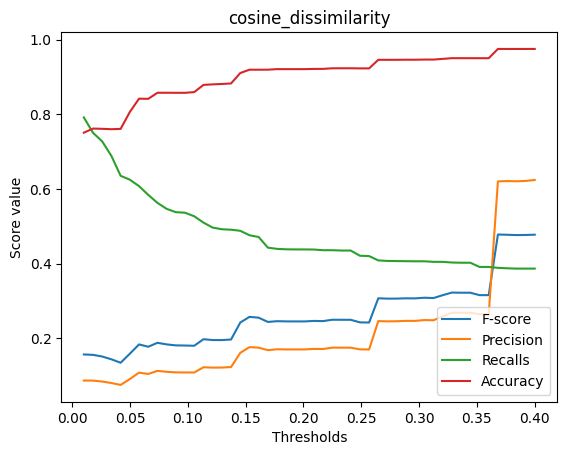

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


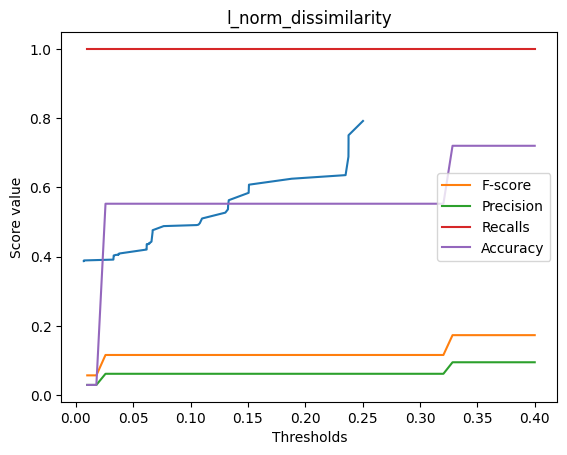

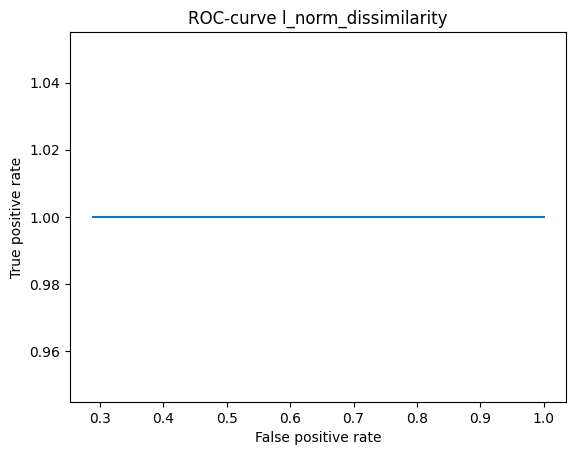

In [4]:
x_train, y_train, x_test, y_test = train_test_split_for_data_autoencoder('../Data/HDFS_v1/Processed_data/processed_labeled_data.csv', 0.2, False)

for i in range(len(numbers_of_neurons)):
    model_number = "model"+str(i+1)

    init_dictionary = {'number of neurons' : numbers_of_neurons[i],
                'activation function': activation_functions[i],
                'kernel initializer': kernel_initializers[i],
                'learning rate': 0.01,
                'loss function': 'mean_squared_error'}

    fit_dictionary = {'x_train' : x_train,
                    'epochs': 100,
                    'batch size': 128,
                    'validation split': 0.2,
                    'path': "../Models/" + model_number + "/autoencoder_model_unsupervised_nonsequential.keras"
    }
    autoencoder = AutoEncoder(init_dictionary)
    autoencoder.model.summary()
    history = autoencoder.fit(fit_dictionary)
    history_save_name = '../Results/' + model_number + '/unsupervised_history.png'
    autoencoder.plot_history(history, history_save_name)
    evaluate_feature_dict = {'x_test': x_test,
                            'y_test': y_test,
                            'difference calculating function': difference_calculating_function_cosine_dissimilarity,
                            'threshold of difference': 0.1,
                            'with confusion matrix': True}
    precision, recall, f_score, accuracy, true_positive_rate, false_positive_rate = autoencoder.evaluate(evaluate_feature_dict)
    thresholds = np.linspace(start = 0.01, stop = 0.4, num = 50, endpoint = True)
    autoencoder.create_f_score_recall_precision_plots(difference_calculating_function_cosine_dissimilarity, x_test, y_test, thresholds, 'cosine_dissimilarity', '../Results/' + model_number + '/unsupervised_cosine')
    autoencoder.create_f_score_recall_precision_plots(difference_calculating_function_l_norm, x_test, y_test, thresholds, 'l_norm_dissimilarity', '../Results/' + model_number + '/unsupervised_lnorm')


In [10]:

history_save_name = '../Results/' + model_number + '/unsupervised_history.png'
history_save_name

'../Results/model1/unsupervised_history.png'

## Semisupervised autoencoder

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 48)             │         1,584 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,932 (27.08 KB)

 Trainable params: 6,932 (27.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11152/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2491
Epoch 1: val_loss improved from inf to 0.20186, saving model to ../Models/model1/autoencoder_model_semisupervised_nonsequential.keras
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.2491 - val_loss: 0.2019
Epoch 2/100
11138/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2255
Epoch 2: val_loss improved from 0.20186 to 0.20092, saving model to ../Models/model1/autoencoder_model_semisupervised_nonsequential.keras
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 0.2254 - val_loss: 0.2009
Epoch 3/100
11164/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2086
Epoch 3: val_loss did not improve from 0.20092
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 0.2086 - val_loss: 0.2010
Epoch 4/100
11153/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2249
Epoch 4: val_loss did not improve from 0.20092
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 0.2249 - val_loss: 0.2015
Epoch 5/100
11164/11165 ━━

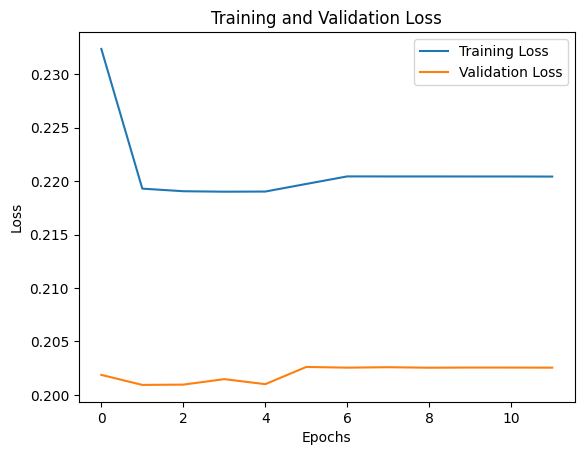

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


<Figure size 640x480 with 0 Axes>

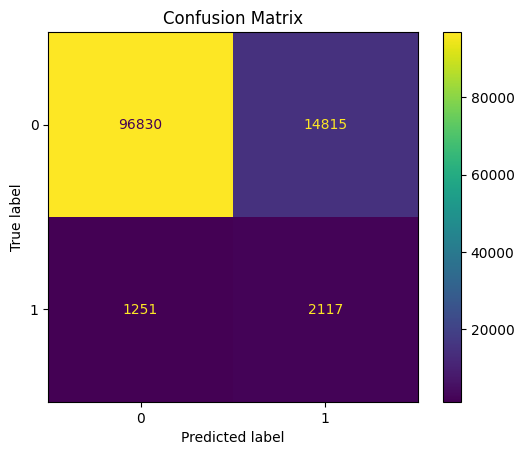

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


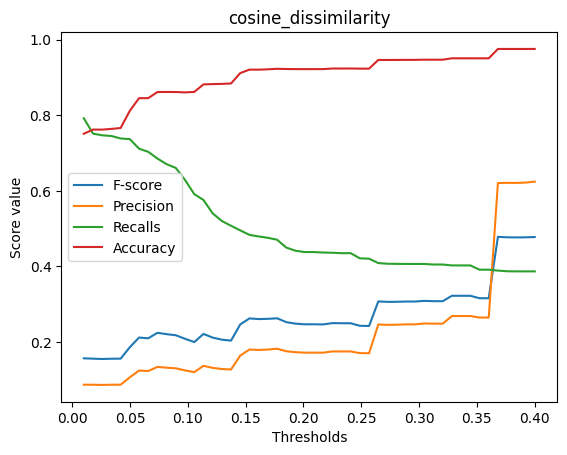

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


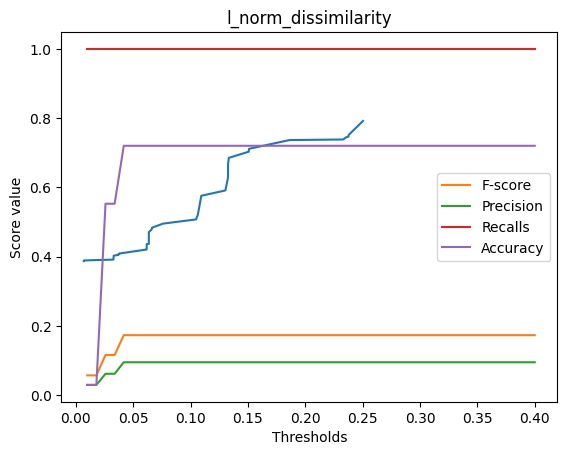

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 24)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 48)             │         1,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,220 (20.39 KB)

 Trainable params: 5,220 (20.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11137/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3558
Epoch 1: val_loss improved from inf to 0.20113, saving model to ../Models/model2/autoencoder_model_semisupervised_nonsequential.keras
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.3556 - val_loss: 0.2011
Epoch 2/100
11151/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2226
Epoch 2: val_loss improved from 0.20113 to 0.20055, saving model to ../Models/model2/autoencoder_model_semisupervised_nonsequential.keras
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.2226 - val_loss: 0.2005
Epoch 3/100
11161/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2184
Epoch 3: val_loss improved from 0.20055 to 0.20054, saving model to ../Models/model2/autoencoder_model_semisupervised_nonsequential.keras
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.2184 - val_loss: 0.2005
Epoch 4/100
11151/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2023
Epoch 4: val_loss did not improve from 0.20054
11165/11165 ━━━

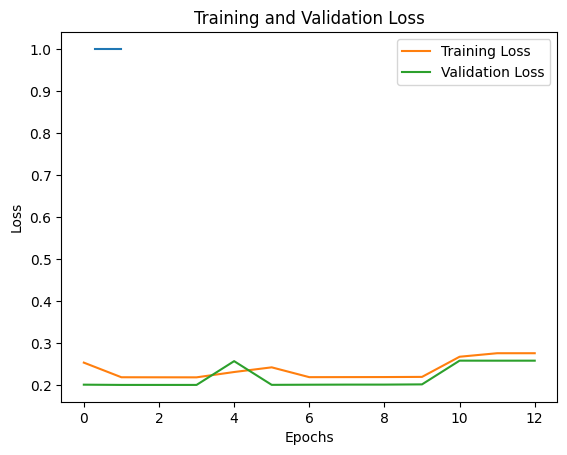

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


<Figure size 640x480 with 0 Axes>

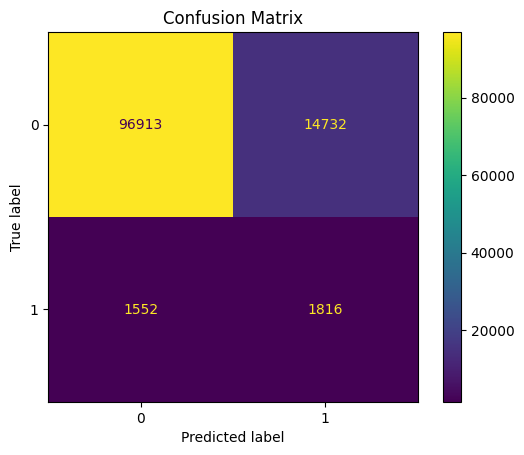

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


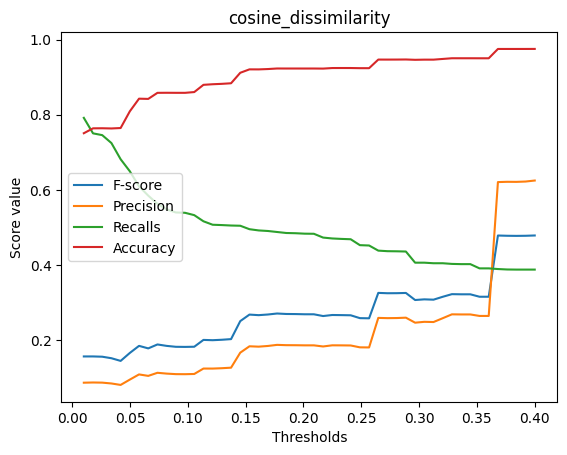

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


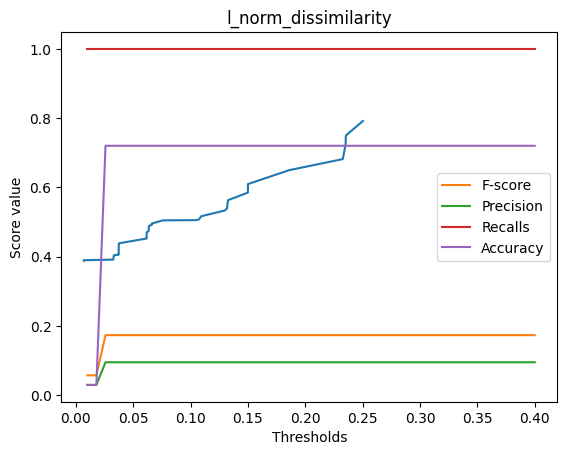

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 4)              │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 12)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 48)             │         1,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,452 (21.30 KB)

 Trainable params: 5,452 (21.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11154/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2671
Epoch 1: val_loss improved from inf to 0.20086, saving model to ../Models/model3/autoencoder_model_semisupervised_nonsequential.keras
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.2670 - val_loss: 0.2009
Epoch 2/100
11137/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2248
Epoch 2: val_loss did not improve from 0.20086
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.2248 - val_loss: 0.2012
Epoch 3/100
11155/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2427
Epoch 3: val_loss did not improve from 0.20086
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 0.2427 - val_loss: 0.2018
Epoch 4/100
11146/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1974
Epoch 4: val_loss did not improve from 0.20086
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.1974 - val_loss: 0.2013
Epoch 5/100
11163/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2081
Epoch 5: val_loss improved from 0.20086 to 0.

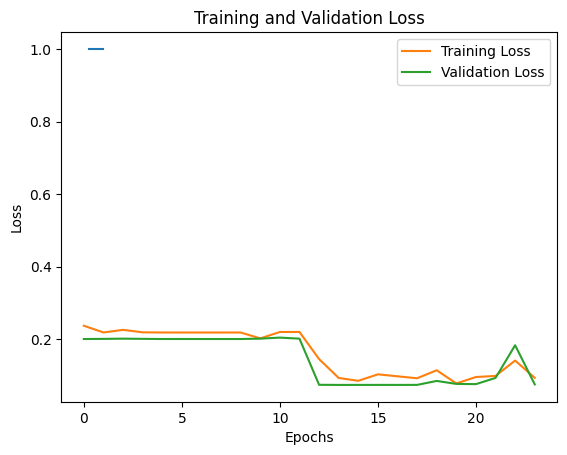

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


<Figure size 640x480 with 0 Axes>

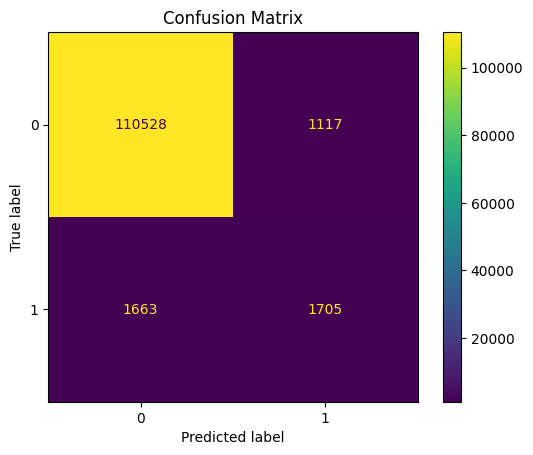

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


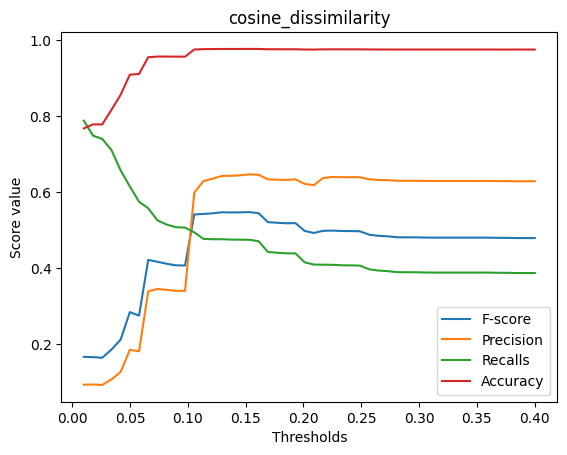

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


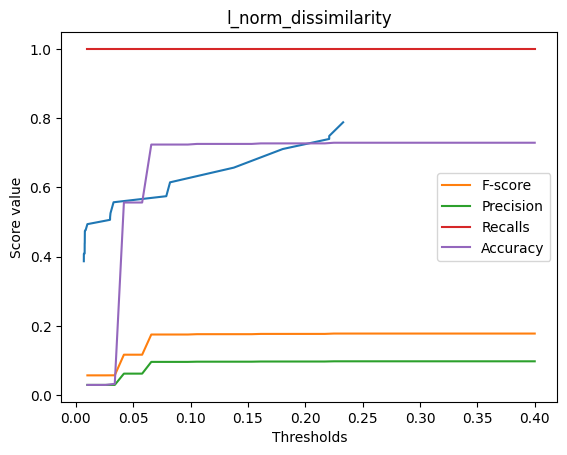

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 48)             │           816 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,308 (16.83 KB)

 Trainable params: 4,308 (16.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11161/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6537
Epoch 1: val_loss improved from inf to 0.69382, saving model to ../Models/model4/autoencoder_model_semisupervised_nonsequential.keras
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.6537 - val_loss: 0.6938
Epoch 2/100
11146/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6879
Epoch 2: val_loss improved from 0.69382 to 0.56908, saving model to ../Models/model4/autoencoder_model_semisupervised_nonsequential.keras
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 0.6878 - val_loss: 0.5691
Epoch 3/100
11138/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6194
Epoch 3: val_loss improved from 0.56908 to 0.56905, saving model to ../Models/model4/autoencoder_model_semisupervised_nonsequential.keras
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 0.6193 - val_loss: 0.5691
Epoch 4/100
11150/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5806
Epoch 4: val_loss did not improve from 0.56905
11165/11165 ━━━

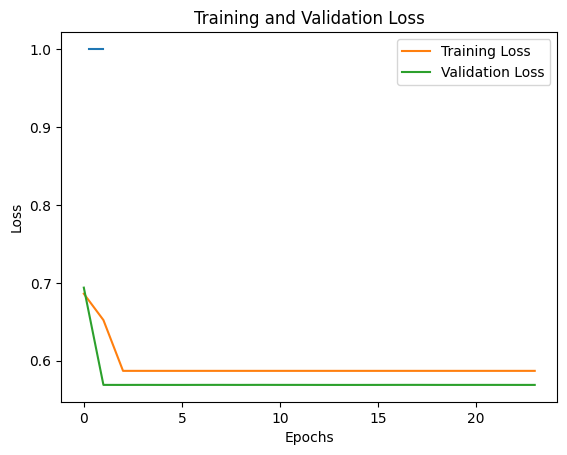

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


<Figure size 640x480 with 0 Axes>

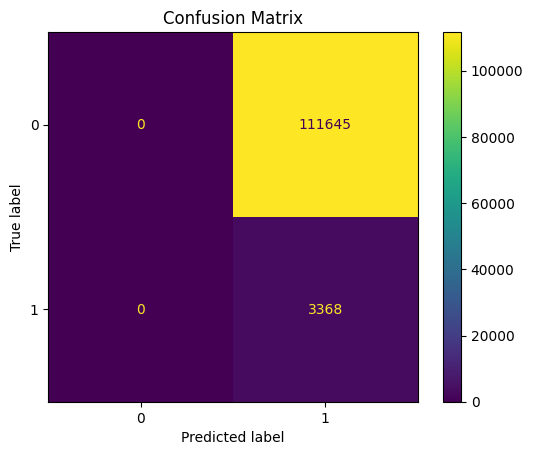

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


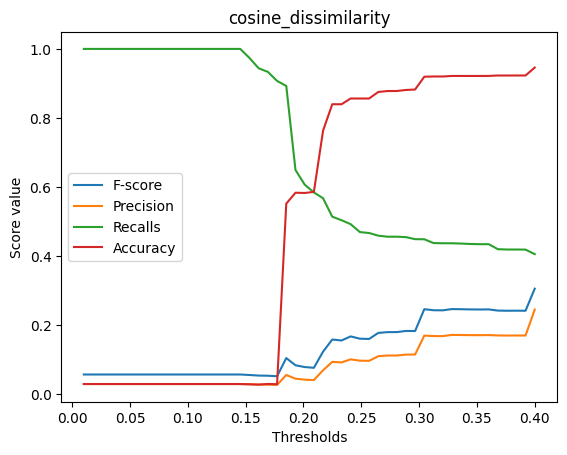

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


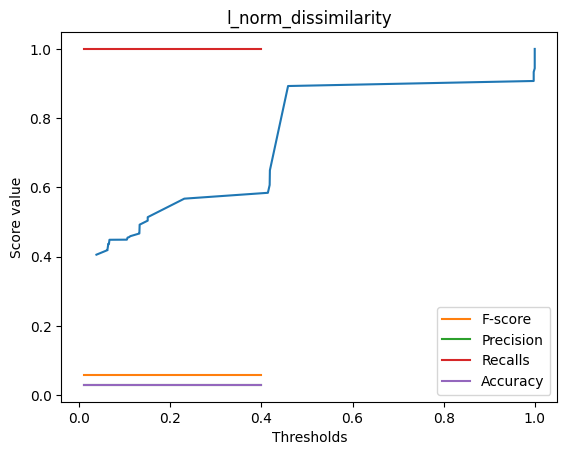

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_71 (Dense)                │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 48)             │         1,584 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,260 (32.27 KB)

 Trainable params: 8,260 (32.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
11155/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2749
Epoch 1: val_loss improved from inf to 0.23846, saving model to ../Models/model5/autoencoder_model_semisupervised_nonsequential.keras
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.2749 - val_loss: 0.2385
Epoch 2/100
11144/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2361
Epoch 2: val_loss improved from 0.23846 to 0.23821, saving model to ../Models/model5/autoencoder_model_semisupervised_nonsequential.keras
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.2362 - val_loss: 0.2382
Epoch 3/100
11151/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2606
Epoch 3: val_loss did not improve from 0.23821
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.2606 - val_loss: 0.2383
Epoch 4/100
11146/11165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2594
Epoch 4: val_loss did not improve from 0.23821
11165/11165 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.2594 - val_loss: 0.2385
Epoch 5/100
11148/11165 ━━

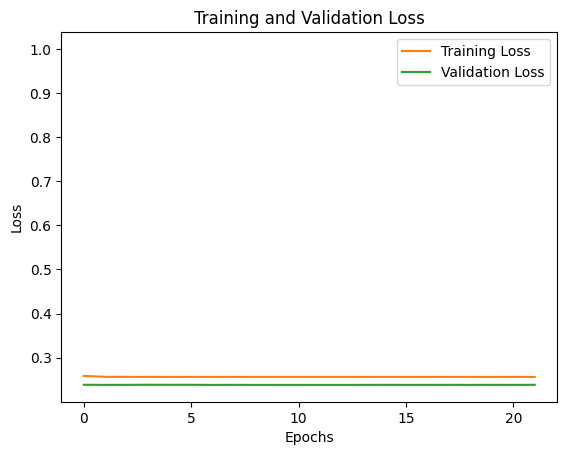

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


<Figure size 640x480 with 0 Axes>

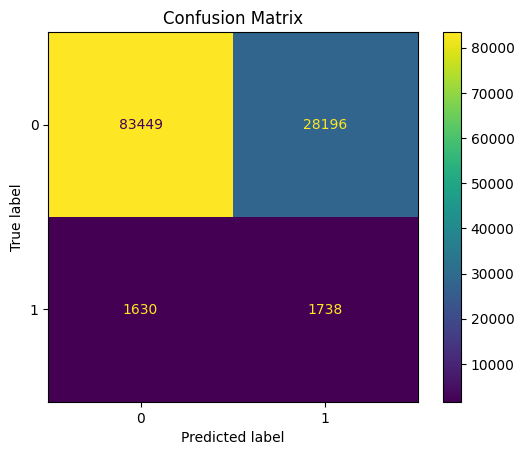

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


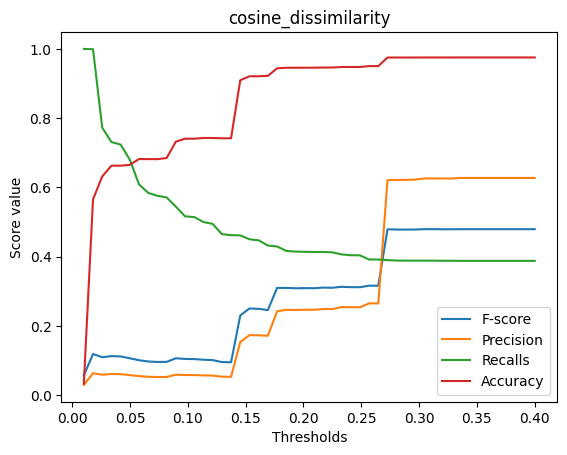

Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Validation error: isinstance() arg 2 must be a type, a tuple of types, or a union
3595/3595 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


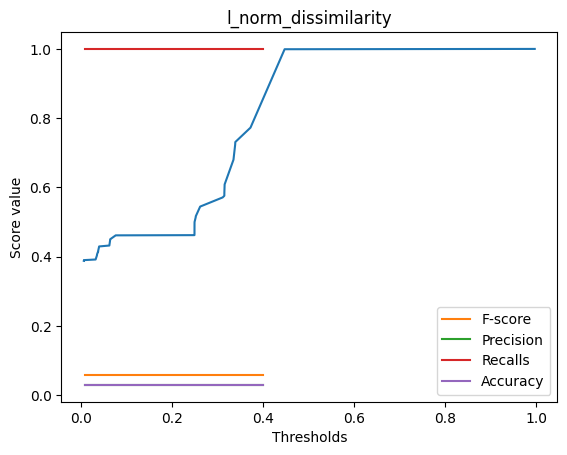

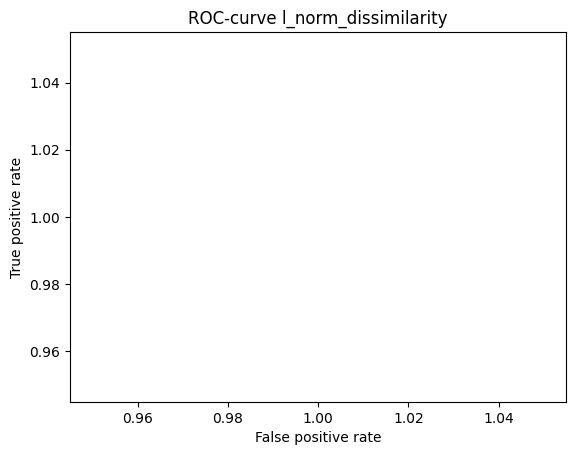

In [5]:
x_train_success, y_train_success, x_test_success, y_test_success, x_train_fail, y_train_fail, x_test_fail, y_test_fail = train_test_split_for_data_autoencoder('../Data/HDFS_v1/Processed_data/processed_labeled_data.csv', 0.2, True)
x_test = pd.concat([x_test_success, x_test_fail], ignore_index=True)
y_test = pd.concat([y_test_success, y_test_fail], ignore_index=True)

for i in range(len(numbers_of_neurons)):
    model_number = "model"+str(i+1)

    init_dictionary = {'number of neurons' : numbers_of_neurons[i],
                'activation function': activation_functions[i],
                'kernel initializer': kernel_initializers[i],
                'learning rate': 0.01,
                'loss function': 'mean_squared_error'}

    fit_dictionary = {'x_train' : x_train_success,
                    'epochs': 100,
                    'batch size': 128,
                    'validation split': 0.2,
                    'path': "../Models/" + model_number + "/autoencoder_model_semisupervised_nonsequential.keras"
    }
    autoencoder = AutoEncoder(init_dictionary)
    autoencoder.model.summary()
    history = autoencoder.fit(fit_dictionary)
    autoencoder.plot_history(history, '../Results/' + model_number + '/semisupervised_history.png')

    evaluate_feature_dict = {'x_test': x_test,
                            'y_test': y_test,
                            'difference calculating function': difference_calculating_function_cosine_dissimilarity,
                            'threshold of difference': 0.1,
                            'with confusion matrix': True}
    precision, recall, f_score, accuracy, true_positive_rate, false_positive_rate = autoencoder.evaluate(evaluate_feature_dict)
    thresholds = np.linspace(start = 0.01, stop = 0.4, num = 50, endpoint = True)
    autoencoder.create_f_score_recall_precision_plots(difference_calculating_function_cosine_dissimilarity, x_test, y_test, thresholds, 'cosine_dissimilarity', '../Results/' + model_number + '/semisupervised_cosine')
    autoencoder.create_f_score_recall_precision_plots(difference_calculating_function_l_norm, x_test, y_test, thresholds, 'l_norm_dissimilarity', '../Results/' + model_number + '/semisupervised_lnorm')

